<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/Diffusion_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1D Diffusion**

This notebook validates the Fokker-Planck like equation derived in the paper Craske J. et al. 2024 by computing each of the relevant terms numerically for the case of 1D scalar diffusion on a bounded domain. To solve this equation we use the open source pseudo-spectral code Dedalus.

**Setup**

This cell checks if Dedalus is installed and performs some other basic setup.


In [ ]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()


**Content**

First let's import everything we need to run the rest of the notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)
#%matplotlib widget


Next we solve the equation for the scalar concentration
\begin{equation}
\partial_t C = \kappa \partial_z^2 C, \quad z \in [0,1],
\end{equation}
over the time interval $t \in [0,1]$ subject to the Robin boundary conditions
\begin{aligned}
 \Gamma C - \beta \partial_z C &= g_0(t), \quad \text{at} \quad z = 0, \\
 \Gamma C + \beta \partial_z C &= g_1(t), \quad \text{at} \quad z = 1,
\end{aligned}
for the initial condition
\begin{equation}
C(z,t=0) = \sin(2 \pi z)
\end{equation}

In [ ]:
# Parameters
β = 0.5
Γ = 2.0
kappa = .1

def g_0(t):
    return -1;
def g_1(t):
    return  1;

Nz=512
stop_sim_time = .125*(1./kappa) # Less than a diffusion time so not a steady state solution
timestep      = 1e-03

zcoord = d3.Coordinate('z')
dist   = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.ChebyshevT(zcoord, size=Nz, bounds=(0,1),dealias=3/2)

# Fields
C      = dist.Field(name='c', bases=zbasis)
tau_c1 = dist.Field(name='tau_c1')
tau_c2 = dist.Field(name='tau_c2')
g0     = dist.Field(name='g0')
g1     = dist.Field(name='g1')

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
Cz = dz(C)  + lift(tau_c1)
Czz= dz(Cz) + lift(tau_c2)

# Problem
problem = d3.IVP([C, tau_c1, tau_c2], namespace=locals())
problem.add_equation("dt(C) - kappa*Czz = 0")
problem.add_equation("Γ*C(z=0) - β*dz(C)(z=0) = g0")
problem.add_equation("Γ*C(z=1) + β*dz(C)(z=1) = g1")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Initial condition
z      = dist.local_grid(zbasis)
C['g'] = np.sin(2.*np.pi*z)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=500)
flow.add_property(d3.Integrate(C**2) , name='<C^2>')
flow.add_property(d3.Integrate(Cz**2), name='<Cz^2>')

# Main loop
logger.info('Starting main loop')
while solver.proceed:

    # Specify the bcs
    g0['g'] = g_0(solver.sim_time)
    g1['g'] = g_1(solver.sim_time)

    solver.step(timestep)
    if (solver.iteration-1) % int(stop_sim_time/(4.*timestep)) == 0:

        C2_avg  = flow.grid_average('<C^2>')
        Cz2_avg = flow.grid_average('<Cz^2>' )

        logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, timestep))
        logger.info('<C^2>=%f, <Cz^2>    =%f'%(C2_avg,Cz2_avg))

    # Capture the last 5 snapshots
    if  solver.iteration == int(stop_sim_time/timestep) - 5:
        snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
        snapshots.add_task(C , layout='g',name='C' ,scales=3/2)
        snapshots.add_task(Cz, layout='g',name='Cz',scales=3/2)

2024-01-23 16:45:06,161 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s
2024-01-23 16:45:06,163 __main__ 0/1 INFO :: Starting main loop
2024-01-23 16:45:06,531 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-03, dt=1.000000e-03
2024-01-23 16:45:06,531 __main__ 0/1 INFO :: <C^2>=0.500000, <Cz^2>    =19.739209
2024-01-23 16:45:06,635 __main__ 0/1 INFO :: Iteration=313, Time=3.130000e-01, dt=1.000000e-03
2024-01-23 16:45:06,636 __main__ 0/1 INFO :: <C^2>=0.500000, <Cz^2>    =19.739209
2024-01-23 16:45:06,741 __main__ 0/1 INFO :: Iteration=625, Time=6.250000e-01, dt=1.000000e-03
2024-01-23 16:45:06,742 __main__ 0/1 INFO :: <C^2>=0.015302, <Cz^2>    =0.866742
2024-01-23 16:45:06,846 __main__ 0/1 INFO :: Iteration=937, Time=9.370000e-01, dt=1.000000e-03
2024-01-23 16:45:06,847 __main__ 0/1 INFO :: <C^2>=0.015302, <Cz^2>    =0.866742
2024-01-23 16:45:06,989 __main__ 0/1 INFO :: Iteration=1249, Time=1.249000e+00, dt=1.000000e-03
2024

**Fokker-Planck like equation**

Having time integrated the transport equation for the solute concentration and generated snapshots of $C(z;t)$ at discrete time intervals on our numerical grid, we now use this data to validate the Fokker-Planck like equation
\begin{equation}
\partial_tf_C = -\partial_c \left( \mathbb{S}(c) f_C \right) - \kappa \partial^2_c \left( \mathbb{E}[ |\nabla C|^2 |C=c]f_C \right),
\end{equation}
which can also be written as
\begin{equation}
\partial_tf_C = \int_0^1  \kappa \partial^2_z f_{C|Z} dz - \kappa \partial^2_c \left( \mathbb{E}[ |\nabla C|^2 |C=c]f_C \right).
\end{equation}
Subject to the knowledge of the source term arising from the boundary conditions and the expectation of the concentration gradient conditional on $C$ this equation governs the time evolution of the probability density $f_C(c;t)$. To see how we evaluate the source term and how this relates to the boundary conditions we begin by loading the numerical snapshots saved

In [ ]:
N_bins=128

# Data loading
file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')

# Interpolate the data from a Chebyshev grid onto a uniform grid
C_cheb  = file['tasks/C' ][:,:]
Cz_cheb = file['tasks/Cz'][:,:]
z_cheb  = file['tasks/C'].dims[1][0][:]
times  = file['tasks/C'].dims[0][0][:]

dz_cheb = z_cheb[1]-z_cheb[0];
z_data  = np.arange(0,1,dz_cheb);
s       = (len(times),len(z_data));
C_data  = np.zeros(s)
Cz_data = np.zeros(s)
for i,t in enumerate(times):
  C_data[i,:] = np.interp(z_data, z_cheb, C_cheb[i,:] )
  Cz_data[i,:]= np.interp(z_data, z_cheb, Cz_cheb[i,:])
dC2_data = Cz_data**2;

We then use these data to estimate the terms in the Fokker-Planck like equation. To evaluate the left hand side we esimate the PDF $f_C$ (as a histogram) and then take its time derivative $\partial_t f_C$ using 4th order central differencing.

In [ ]:
# PDF f_C
f_np2,c = np.histogram(C_data[-1,...].flatten(),bins=N_bins,density=True); # n + 2 (-1)
f_np1,c = np.histogram(C_data[-2,...].flatten(),bins=N_bins,density=True); # n + 1 (-2)

f_nm1,c = np.histogram(C_data[-4,...].flatten(),bins=N_bins,density=True); # n - 1 (-4)
f_nm2,c = np.histogram(C_data[-5,...].flatten(),bins=N_bins,density=True); # n - 2 (-5)

c       = 0.5*(c[1:] + c[:-1]); dc = c[1] - c[0];

# Time derivate df_C/dt
dt   = times[-1] - times[-2];
dfdt = (-1./12.)*f_np2 + (2./3.)*f_np1 - (2./3.)*f_nm1 + (1./12.)*f_nm2;
dfdt /=dt;

To obtain the right hand side we must compute the conditional expectation which we evaluate from its conditional probability
\begin{equation}
\mathbb{E}[ |\nabla C|^2 |C=c] = \int \phi^2 \frac{ f_{ \nabla C|C}(\phi|c) }{f_C(c)} d \phi,
\end{equation}
and the derivative operator $L = \partial_c^2$ for which we again avail of finite differences.

In [ ]:
# Expectation
# Let Φ = |∇C|^2 and φ its dummy variable
f_CΦ,c,φ = np.histogram2d(C_data[-3,...].flatten(), dC2_data[-3,...].flatten(),bins=N_bins,density=True) # n (-3)
φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
c = .5*(c[1:]+c[:-1]); dc = c[1] - c[0];
f_C =  np.sum(  f_CΦ,axis=1)*dφ;      # f_C(c)
E   = (np.sum(φ*f_CΦ,axis=1)*dφ)/f_C; # E{Φ|C} = int_φ f_Φ|C(φ|c)*φ dφ

# Second derivative operator L
# Boundary conditions ?
N = len(c)
L = np.zeros((N,N))
for i in range(N):

    if i == 0:
        L[i,i  ] = -2.
        L[i,i+1] =  1
    elif i == N-1:
        L[i,i-1] =  1.
        L[i,i  ] = -2
    else:
        L[i,i-1] =  1
        L[i,i  ] = -2.
        L[i,i+1] =  1

L   *= 1./(dc**2);

Evaluation of the source term is somewhat more involved. We being by making the following manipulations
\begin{equation} %-\frac{\partial }{\partial c} \left( \mathbb{S}(c) f_C \right)
\int_0^1 \frac{\partial^2 f_{C|Z} }{\partial z^2} dz  = -\frac{\partial }{\partial c} \left( \mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C,Z \right\} f_{C|Z} \right)|_{Z=1,0},
\end{equation}
such that our boundary conditions simplifies to
\begin{equation}
\frac{\partial f_{C|Z} }{\partial z} |_{Z=1,0} = - \frac{\partial }{\partial c} \left( \mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C,Z=1 \right\} f_{C|Z=1} - \mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C,Z=0 \right\} f_{C|Z=0} \right),
\end{equation}
from which we can eliminate the conditional probabilities as they reduce to delta functions at $z=1,0$
\begin{equation}
f_{C|Z}(c|z=1) = \delta(c - C(Z=1)), \quad f_{C|Z}(c|z=0) = \delta(c - C(Z=0)).
\end{equation}
At this point we must split the conditional expectations according to the physical boundary conditions prescribed.

**Dirichlet**

For this case $\beta = 0$ and we take $\Gamma=1$ for simplicity such that the conditional expectations reduce to
\begin{equation}
\mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C=c,Z=1 \right\} = \mathbb{E} \left\{ \frac{\partial C}{\partial Z}  \middle| C = g_1,Z=1 \right\}, \quad \mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C=c,Z=0 \right\} = \mathbb{E} \left\{ \frac{\partial C}{\partial Z}  \middle| C = g_0,Z=1 \right\}
\end{equation}
showing that we can know the conditional expectations and thus this boundary term only up to a constant multiple.

**Neumann or Robin boundary conditions**

For this case the conditional expectations reduce to
\begin{equation}
\mathbb{E} \left\{ \frac{g_1 - \Gamma C}{\beta} \middle| C,Z=1 \right\} = \frac{g_1 - \Gamma c}{\beta}, \quad \mathbb{E} \left\{ \frac{g_1 - \Gamma C}{\beta} \middle| C,Z=1 \right\} = \frac{g_0 - \Gamma c}{\beta}.
\end{equation}
which combined with the conditional probabilities above yields
\begin{equation}
\frac{\partial f_{C|Z} }{\partial z} |_{Z=1,0} = -\frac{\partial }{\partial c} \left( \delta(c - C(Z=1))  \left( \frac{g_1 - \Gamma c}{\beta} \right) + \delta(c - C(Z=0))  \left( \frac{g_0 - \Gamma c}{\beta} \right) \right).
\end{equation}
A particularly simple case is the fixed flux boundary conditions (i.e. $\Gamma=0, \beta=1$)
\begin{equation}
-\partial_z C(Z=0) = 1, \quad \partial_z C(Z=1) = 1,
\end{equation}
corresponding to a flux of concentration into the domain at $Z=0$ and out of the domain at $Z=1$, for which the above source term reduces to
\begin{equation}
\frac{\partial f_{C|Z} }{\partial z} |_{Z=1,0} = -\frac{\partial }{\partial c} \left( \delta(c - C(Z=1)) + \delta(c - C(Z=0)) \right),
\end{equation}
a delta function at each end of the domain.

To compare the left and right hand sides of the Fokker-Planck like equation we then, rather than differentiating delta functions or the potentially noisy numerically evaluated terms, opt to twice integrate the left hand side. Numerically this is achieved by inverting $L$ onto $\partial_t f_S$, while we treat the above source term analytically. Using the fact that
\begin{equation}
\int y(c)\delta(c - a) dc = y(a)H(c - a) + const,
\end{equation}
where $H(x)$ denotes the heavisde step function we can write
\begin{aligned}
    \int \frac{\partial f_{C|Z} }{\partial z} |_{Z=1,0} dc &=  H(c - C(Z=1)) \left( \frac{g_1 - C(Z=1)}{\beta} \right) + H(c - C(Z=0))  \left( \frac{g_0 - C(Z=0)}{\beta} \right) + const, \\
                                                           &= H(c - C(Z=0))  \left( \frac{g_0 - C(Z=0)}{\beta} \right),
\end{aligned}
as the first term is non-zero only outside the domain. We now evaluate this below to treat Neumann and Robin boundary conditions

In [ ]:
# Source term
g0 = g_0(times[-3])
g1 = g_1(times[-3])

# Integrated source term
int_Sf_C = 0.*c;
int_Sf_C[:] = (g0 - Γ*C_data[-3, 0])/β; #print(kappa*(g0 - Γ*C_data[-3, 0])/β)
#int_Sf_C[:] += (g1 - Γ*C_data[-3,-1])/β; print((g1 - Γ*C_data[-3, -1])/β) # D#oesn't contribute


 ~~~~~~~~~~~ Fokker Planck Equation error ~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Error between LHS and RHS =  0.03656719640427844
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 
2024-01-23 16:45:07,726 matplotlib.mathtext 0/1 INFO :: Substituting symbol S from STIXNonUnicode
2024-01-23 16:45:07,733 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-01-23 16:45:07,790 matplotlib.mathtext 0/1 INFO :: Substituting symbol S from STIXNonUnicode
2024-01-23 16:45:07,796 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-01-23 16:45:07,985 matplotlib.mathtext 0/1 INFO :: Substituting symbol S from STIXNonUnicode
2024-01-23 16:45:07,992 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-01-23 16:45:08,195 matplotlib.mathtext 0/1 INFO :: Substituting symbol S from STIXNonUnicode
2024-01-23 16:45:08,203 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


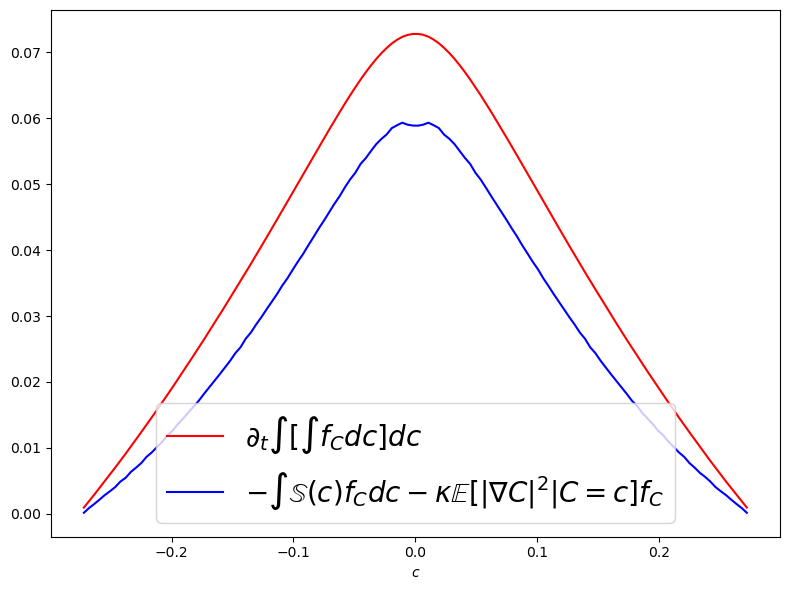

In [ ]:
# Compare equation terms
LHS = np.linalg.inv(L)@dfdt;
RHS = -kappa*int_Sf_C - kappa*E*f_C

error = np.trapz(LHS+RHS,c)
print('\n ~~~~~~~~~~~ Fokker Planck Equation error ~~~~~~~~~~~~~~~~~~~~~~~~~~ ')
print('Error between LHS and RHS = ',error)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n ')


fig = plt.figure(figsize=(8,6))

plt.plot(c,LHS,'r-',label=r'$\partial_t \int [\int f_C dc] dc$')
plt.plot(c,RHS,'b-',label=r'$- \int \mathbb{S}(c) f_C dc -\kappa \mathbb{E}[ |\nabla C|^2 |C=c] f_C $')

plt.xlabel(r'$c$')
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('Equation_terms_HIST.png',dpi=200)
plt.show()

Plotting these terms above we see that the left and right hand sides balance thus numerically validating our equation for this example. Below we also plot the PDF conditional expectation and the scalar conecentration $C(z;t=1)$.

2024-01-23 16:45:08,464 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-01-23 16:45:08,626 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-01-23 16:45:08,986 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-01-23 16:45:09,273 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


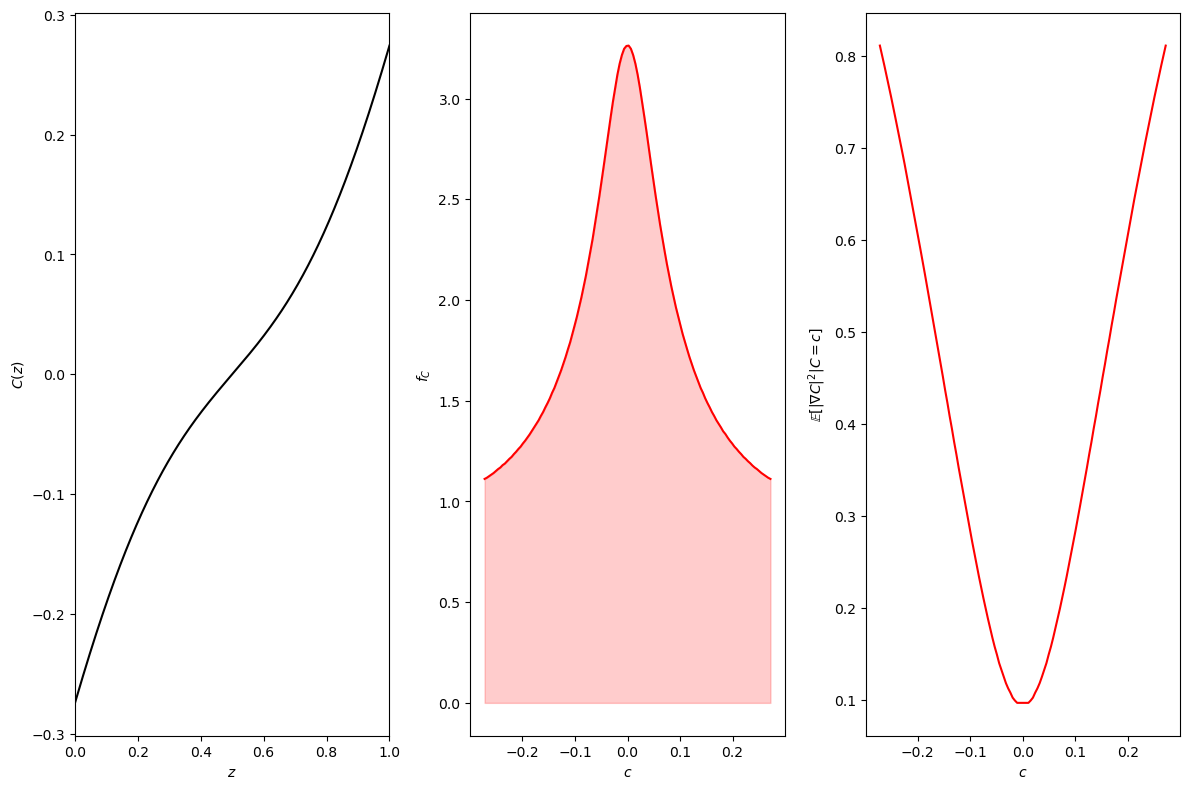

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(12,8))

axs[0].plot(z_data,C_data[-1,:],'k')
axs[0].set_xlim([0,1])
axs[0].set_ylabel(r'$C(z)$')
axs[0].set_xlabel(r'$z$')

axs[1].plot(c,f_C,'r')
axs[1].fill_between(x=c,y1=f_C,color= "r",alpha= 0.2)
axs[1].set_ylabel(r'$f_C$')
axs[1].set_xlabel(r'$c$')

axs[2].plot(c,E,'r')
axs[2].set_ylabel(r'$\mathbb{E}[|\nabla C|^2 |C=c]$')
axs[2].set_xlabel(r'$c$')

plt.tight_layout()
plt.savefig('Field_And_PDF.png',dpi=200)
plt.show()